In [77]:
import os
from pkg_resources import packaging
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import clip
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from deepul_helper.tasks import *


print("Torch version:", torch.__version__)


Torch version: 1.11.0


### Use pretrained ViT-B/32 model from CLIP package

In [78]:
model, preprocess = clip.load("ViT-B/32")
# model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


### CLIP use vision transformer for image classification and transformer for text classification

In [79]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

### Use Rotation Prediction self supervised trained model as image classifier instead of vision transformer

In [80]:
# CIFAR-10 classes 
num_classes = 10 
image_net = CustomNetwork('cifar10', 10)

# set linear classifier to match the dimensions of text encoder
linear_classifier = nn.Linear(4,512)

In [81]:
model.visual = image_net

In [82]:
model

CLIP(
  (visual): CustomNetwork(
    (model): NetworkInNetwork(
      (_feature_blocks): ModuleList(
        (0): Sequential(
          (Block1_ConvB1): BasicBlock(
            (layers): Sequential(
              (Conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
              (BatchNorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (ReLU): ReLU(inplace=True)
            )
          )
          (Block1_ConvB2): BasicBlock(
            (layers): Sequential(
              (Conv): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (BatchNorm): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (ReLU): ReLU(inplace=True)
            )
          )
          (Block1_ConvB3): BasicBlock(
            (layers): Sequential(
              (Conv): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (BatchNorm): BatchNo

In [83]:
# CIFAR-10 classe 
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

text_descriptions = [f"This is a photo of a {label}" for label in classes]
print(text_descriptions)
# descriptions = {
#     # "plane": "a plane flying in the sky",
#     # "car": "a lovely car",
#     # "bird": "a portrait of an astronaut with the American flag",
#     # "cat": "a rocket standing on a launchpad",
#     # "deer": "a red motorcycle standing in a garage",
#     # "dog": "a person looking at a camera on a tripod",
#     # "frog": "a black-and-white silhouette of a horse", 
#     # "horse": "a black-and-white silhouette of a horse"
# }

['This is a photo of a plane', 'This is a photo of a car', 'This is a photo of a bird', 'This is a photo of a cat', 'This is a photo of a deer', 'This is a photo of a dog', 'This is a photo of a frog', 'This is a photo of a horse', 'This is a photo of a ship', 'This is a photo of a truck']


### Resize images to 32x32

In [84]:
transform_image = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

### Open folders in the same order as classes so that model can predict correctly

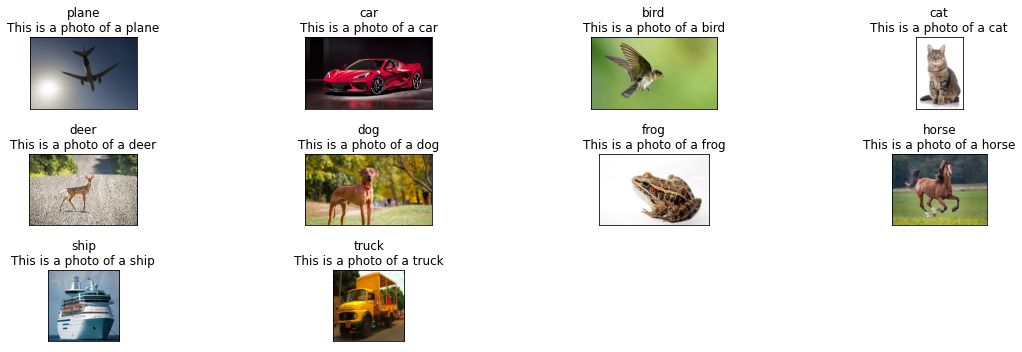

In [85]:
data_path = "./data"
os.listdir(data_path)
original_images = []
images = []

# how many images to pick from a folder 
num_images = 1 

plt.figure(figsize=(16, 5))

for i, name in enumerate(classes):
    # pick one image from the folder. This loop should include another loop if we want more than one image 
    image = os.listdir(os.path.join(data_path, name))[:num_images][0]
    # print(image)
    image_path = os.path.join(data_path, name, image)
    image = Image.open(image_path).convert("RGB")
    
    plt.subplot(3, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{name}\n{text_descriptions[i]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(transform_image(image))

plt.tight_layout()

In [86]:
# original_images = []
# images = []
# texts = []
# plt.figure(figsize=(16, 5))

# for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
#     name = os.path.splitext(filename)[0]
#     if name not in descriptions:
#         continue

#     image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
#     plt.subplot(2, 4, len(images) + 1)
#     plt.imshow(image)
#     plt.title(f"{filename}\n{descriptions[name]}")
#     plt.xticks([])
#     plt.yticks([])

#     original_images.append(image)
#     images.append(preprocess(image))
#     texts.append(descriptions[name])

# plt.tight_layout()

### Create a batch of images

In [87]:
image_batch= torch.stack(images)
image_batch.shape

torch.Size([10, 3, 32, 32])

In [88]:
logits = model.visual(image_batch)

In [89]:
logits.shape

torch.Size([10, 4])

### Pass all the logits through final linear classifier


In [90]:
image_features = []
for logit in logits:
    image_features.append(linear_classifier(logit))

# print(image_features.shape)

In [93]:
for item in image_features:
    print(type(item))
    print(item.shape)

<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])
<class 'torch.Tensor'>
torch.Size([512])


In [94]:
image_features_batch = torch.stack(image_features)
print(image_features_batch.shape)

torch.Size([10, 512])


In [45]:
# _, predicted = image_features.max(1)
# print(predicted.item())

478


In [95]:
def encode_text(text):
    x = model.token_embedding(text).type(torch.float32)  # [batch_size, n_ctx, d_model]

    x = x + model.positional_embedding.type(torch.float32)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = model.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = model.ln_final(x).type(torch.float32)

    # x.shape = [batch_size, n_ctx, transformer.width]
    # take features from the eot embedding (eot_token is the highest number in each sequence)
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ model.text_projection

    return x

In [98]:
text_tokens = clip.tokenize(text_descriptions)
text_features_batch = encode_text(text_tokens).float()
text_features_batch.shape

torch.Size([10, 512])

In [101]:
image_features_batch /= image_features_batch.norm(dim=-1, keepdim=True)
text_features_batch /= text_features_batch.norm(dim=-1, keepdim=True)
similarity = text_features_batch.detach().cpu().numpy() @ image_features_batch.detach().cpu().numpy().T

In [105]:
similarity.shape

(10, 10)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

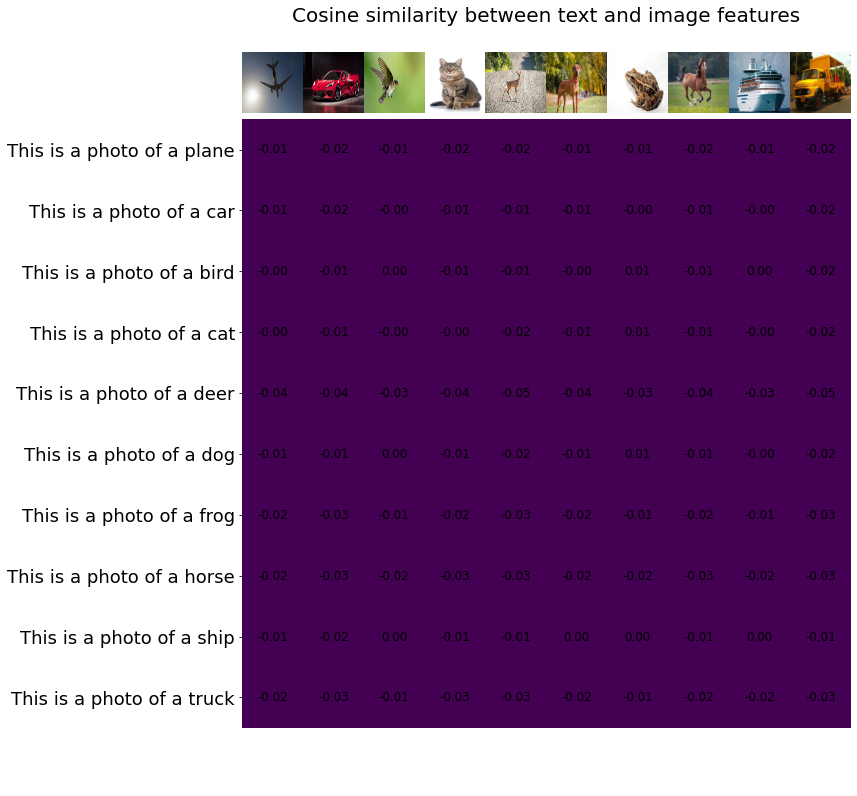

In [106]:
count = len(text_descriptions)
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), text_descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)